# Analysis of PELT signal error due to skip last window update

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2017-07-25 18:34:56,088 INFO    : root         : Using LISA logging configuration:
2017-07-25 18:34:56,090 INFO    : root         :   /home/joelaf/repo/lisa-aosp/external/lisa/logging.conf


In [2]:
# Generate plots inline
%matplotlib inline
import json
import os
from trace import Trace
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import trappy

path_to_dat = "/home/joelaf/repo/lisa-aosp/external/lisa/ipynb/scratchpad/pelt-error/trace.dat"

## Parse Trace and Profiling Data

In [3]:
trace = Trace(None, path_to_dat, events=[ 'sched_switch', 'pelt_update' ])

## Trace visualization

In [4]:
trappy.plotter.plot_trace(trace.ftrace)

## Latency DataFrames

In [5]:
df = trace.data_frame.trace_event('pelt_update')
rq_df = df[df.cfs_rq == 1]
rq_df.columns

Index([u'__comm', u'__cpu', u'__line', u'__pid', u'__tgid', u'acc_load_avg',
       u'acc_util_avg', u'cfs_rq', u'delta_us', u'load_avg', u'load_err',
       u'load_sum', u'sum_err', u'util_avg', u'util_err'],
      dtype='object')

In [6]:
# Plot the accurate and the actual signals for the RQ
print 'UTIL ERROR'
trappy.ILinePlot(trace.ftrace,
                signals = [
                    'pelt_update:util_avg',
                    'pelt_update:acc_util_avg',
                ]).view()

print 'LOAD ERROR'
trappy.ILinePlot(trace.ftrace,
                signals = [
                    'pelt_update:load_avg',
                    'pelt_update:acc_load_avg',
                ]).view()

UTIL ERROR


""
""


LOAD ERROR


""
""


Data showing util/load errors on the RQ (cpu 1) when thread0 running
-------------------------------
Note that, as expected, the error exists only for cases where delta is < 1ms (now - last_update_time)

In [31]:
errpc_fn = (lambda row: (row['util_err'] * 100.0 / row['util_avg']))

err_df = rq_df[(rq_df.util_err > 10) | (rq_df.load_err > 10)][rq_df['__comm'] == 'thread0']
err_df = err_df[['__comm',  'acc_load_avg', 'util_avg', 'acc_util_avg', \
                 'util_err', 'delta_us', 'load_sum', 'sum_err', 'load_avg', 'load_err']]

err_df['util_err_pc'] = err_df.apply(errpc_fn ,axis=1)

err_df = err_df.sort(columns=['util_err_pc'], ascending=False)
print 'number of errors: ' + str(len(err_df))

err_df.head(40)


number of errors: 11


/home/joelaf/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/home/joelaf/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,__comm,acc_load_avg,util_avg,acc_util_avg,util_err,delta_us,load_sum,sum_err,load_avg,load_err,util_err_pc
Time,,,,,,,,,,,
6.986053,thread0,91,76,89,13,45,4356860,-46080,76,15,17.105263
3.749162,thread0,88,75,87,12,519,4219977,-531456,76,12,16.000000
3.749187,thread0,88,75,87,12,28,4248649,-28672,76,12,16.000000
6.986014,thread0,90,76,88,12,590,4310780,-604160,76,14,15.789474
4.355859,thread0,85,73,83,10,435,4059408,-445440,74,11,13.698630
4.355883,thread0,85,73,83,10,27,4087056,-27648,74,11,13.698630
6.075973,thread0,86,75,85,10,27,4125064,-27648,75,11,13.333333
5.982620,thread0,227,211,225,14,684,10844301,-700416,212,15,6.635071
0.736533,thread0,401,380,398,18,854,19171804,-874496,383,18,4.736842


# Summary of issues

### * At 5.98s, there is a 6% error in util_avg 225 vs 211) - this causes a glitch and makes the signal less smooth
----
![glitch](pelt-signal-glitch-error-6pc.png)


### * At 3.06s, there is a 3% error in util_avg - causing lowered peak of util_avg (397 -> 387) with delta ~450us
![lower-peak](pelt-3percent-error.png)


<p style="page-break-after:always;"></p>
# Histogram of Errors before and after fix

## BEFORE: util_avg and load_avg occurences of errors

/home/joelaf/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


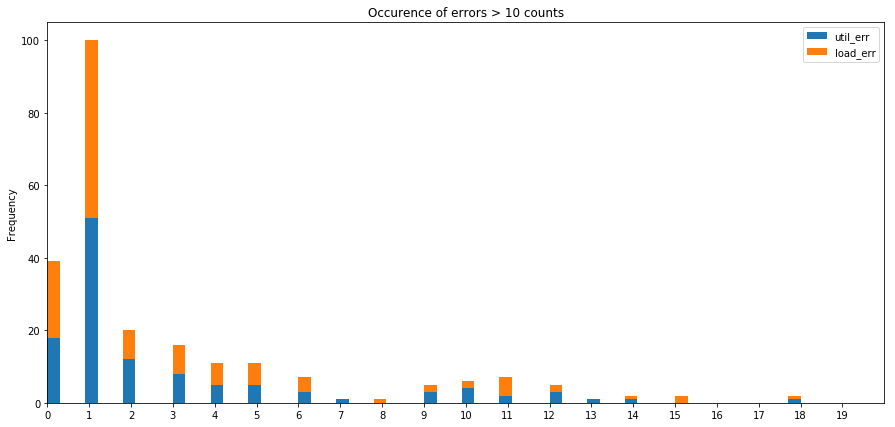

In [8]:
df = rq_df[(rq_df.util_err > 0) | (rq_df.load_err > 0)][rq_df['__comm'] == 'thread0']
df = df[(df.util_err > 0) | (df.load_err > 0)]
df = df[['util_err', 'load_err']].plot(kind='hist', figsize=(15,7), bins=60, xlim=(0, 20), xticks=range(0,20), stacked=True, title = 'Occurence of errors > 10 counts', )

## AFTER fix: util_avg and load_avg occurences of errors

![fixed](pelt-hist-fixed.png)